In [1]:
# %load plot_EEG_Example.py
%matplotlib notebook
"""
=================================
Epilepsy Detection Using EEG Data
=================================

In this example we'll use the |cesium|_ library to compare
various techniques for epilepsy detection using a classic EEG time series dataset from
`Andrzejak et al.  <http://www.meb.uni-bonn.de/epileptologie/science/physik/eegdata.html>`_.
The raw data are separated into five classes: Z, O, N, F, and S; we will consider a
three-class classification problem of distinguishing normal (Z, O), interictal (N, F), and
ictal (S) signals.

The overall workflow consists of three steps: first, we "featurize" the time series by
selecting some set of mathematical functions to apply to each; next, we build some
classification models which use these features to distinguish between classes;
finally, we validate our models by generating predictions for some unseen
holdout set and comparing them to the true class labels.

First, we'll load the data and inspect a representative time series from each class:

.. |cesium| replace:: ``cesium``
.. _cesium: https://github.com/cesium-ml/cesium
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from cesium import datasets

eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [2]:
len(eeg['measurements'])

500

<IPython.core.display.Javascript object>


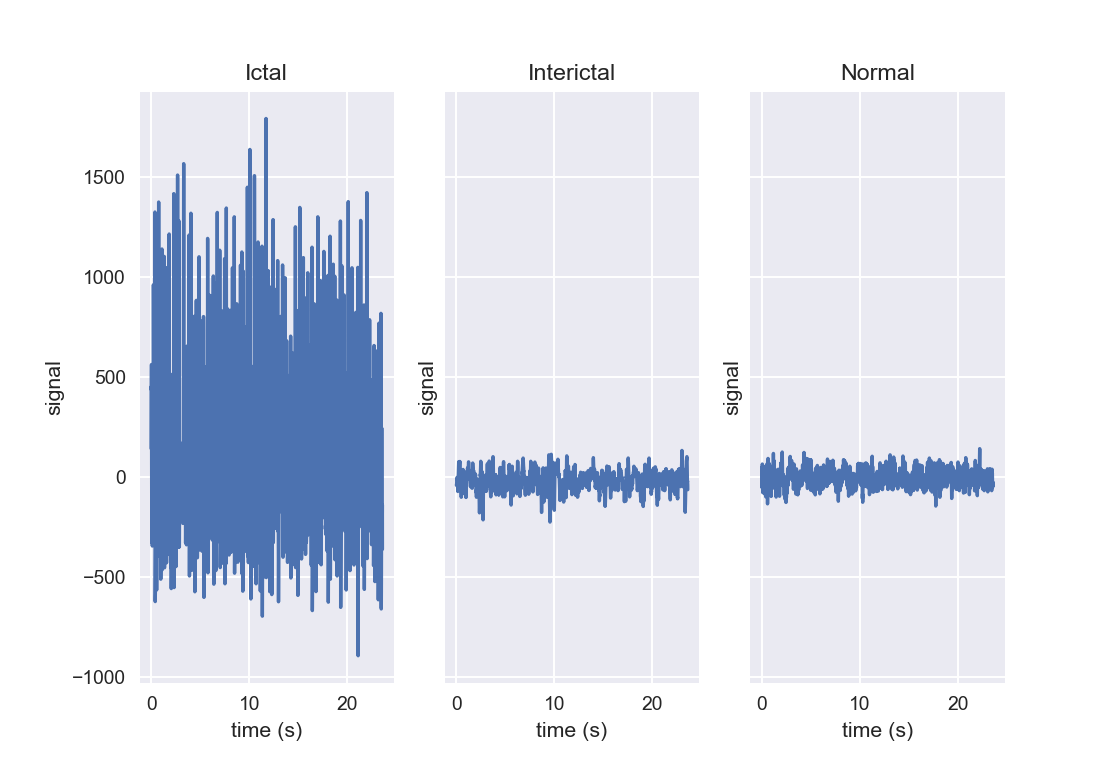

feature amplitude percent_beyond_1_std maximum     max_slope median  \
channel         0                    0       0             0      0   
0           143.5             0.162558   141.0  11107.796610   -4.0   
1           211.5             0.145472   169.0  20653.559322  -51.0   
2           165.0             0.152307   184.0  13537.627119   13.0   
3           171.5             0.152307   162.0  17008.813559   -4.0   
4           170.0             0.152062   152.0  13016.949153  -18.0   

feature median_absolute_deviation percent_close_to_median minimum      skew  \
channel                         0                       0       0         0   
0                            28.0                0.505004  -146.0  0.032805   
1                            32.0                0.640469  -254.0 -0.092715   
2                            31.0                0.515987  -146.0 -0.004100   
3                            31.0                0.541128  -181.0  0.063678   
4                           

In [3]:
# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names
eeg["classes"][(eeg["classes"]=="Z")|(eeg["classes"]=="O")] = "Normal"
eeg["classes"][(eeg["classes"]=="N")|(eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)


###############################################################################
# Featurization
# -------------
# Once the data is loaded, we can generate features for each time series using the
# |cesium.featurize|_ module. The ``featurize`` module includes many built-in
# choices of features which can be applied for any type of time series data;
# here we've chosen a few generic features that do not have any special
# biological significance.
#
# By default, the time series will featurized in parallel using the
# ``dask.multiprocessing`` scheduler; other approaches, including serial and
# distributed approaches, can be implemented by passing in other ``dask``
# schedulers as the ``get`` argument to ``featurize_time_series``.
#
# .. |cesium.featurize| replace:: ``cesium.featurize``
# .. _cesium.featurize: http://cesium-ml.org/docs/api/cesium.featurize.html

from cesium import featurize
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]
fset_cesium = featurize.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())

###############################################################################
# The output of ``featurize_time_series`` is a ``pandas.DataFrame`` which contains all
# the feature information needed to train a machine learning model: feature
# names are stored as column indices (as well as channel numbers, as we'll see
# later for multi-channel data), and the time series index/class label are
# stored as row indices.

###############################################################################
# Custom feature functions
# ~~~~~~~~~~~~~~~~~~~~~~~~
# Custom feature functions not built into ``cesium`` may be passed in using the
# ``custom_functions`` keyword, either as a dictionary ``{feature_name: function}``, or as a
# `dask graph <http://dask.pydata.org/en/latest/custom-graphs.html>`_. Functions should take
# three arrays ``times, measurements, errors`` as inputs; details can be found in the
# ``cesium.featurize``
# `documentation <http://cesium-ml.org/docs/api/cesium.featurize.html>`_.
# Here we'll compute five standard features for EEG analysis provided by
# `Guo et al. (2012) <http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253)>`_:

import numpy as np
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

###############################################################################
# Now we'll pass the desired feature functions as a dictionary via the
# ``custom_functions`` keyword argument.

guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal
}

fset_guo = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                           errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
print(fset_guo.head())

###############################################################################
# Multi-channel time series
# ~~~~~~~~~~~~~~~~~~~~~~~~~
# The EEG time series considered here consist of univariate signal measurements along a
# uniform time grid. But ``featurize_time_series`` also accepts multi-channel
# data; to demonstrate this, we will decompose each signal into five frequency
# bands using a discrete wavelet transform as suggested by
# `Subasi (2005) <http://www.sciencedirect.com/science/article/pii/S0957417404001745>`_,
# and then featurize each band separately using the five functions from above.

import pywt

n_channels = 5
eeg["dwts"] = [pywt.wavedec(m, pywt.Wavelet("db6"), level=n_channels-1)
               for m in eeg["measurements"]]
fset_dwt = featurize.featurize_time_series(times=None, values=eeg["dwts"], errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
print(fset_dwt.head())

###############################################################################
# The output featureset has the same form as before, except now the ``channel``
# component of the column index is used to index the features by the
# corresponding frequency band.

###############################################################################
# Model Building
# --------------
# Featuresets produced by ``cesium.featurize`` are compatible with the ``scikit-learn``
# API. For this example, we'll test a random forest classifier for the
# built-in ``cesium`` features, and a 3-nearest neighbors classifier for the
# others, as suggested by
# `Guo et al. (2012) <http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253>`_.

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

model_cesium = RandomForestClassifier(n_estimators=500, max_features='auto',n_jobs=-1,
                                      random_state=0,bootstrap=True, warm_start=False,
                                     oob_score=True)

model_cesium_guo = RandomForestClassifier(n_estimators=500, max_features='auto',n_jobs=-1,
                                      random_state=0,bootstrap=True, warm_start=False,
                                     oob_score=True)

model_cesium_dwt = RandomForestClassifier(n_estimators=500, max_features='auto',n_jobs=-1,
                                      random_state=0,bootstrap=True, warm_start=0,
                                     oob_score=True)

model_cesium.fit(fset_cesium.iloc[train], eeg["classes"][train])

model_cesium_guo.fit(fset_guo.iloc[train], eeg["classes"][train])

model_cesium_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])

model_guo = KNeighborsClassifier(6)
model_guo.fit(fset_guo.iloc[train], eeg["classes"][train])

model_dwt = KNeighborsClassifier(3)
model_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])

###############################################################################
# Prediction
# ----------
# Making predictions for new time series based on these models follows the same
# pattern: first the time series are featurized using ``featurize_time_series``,
# and then predictions are made based on these features using the ``predict``
# method of the ``scikit-learn`` model.

from sklearn.metrics import accuracy_score

preds_cesium = model_cesium.predict(fset_cesium)
preds_guo = model_guo.predict(fset_guo)
preds_dwt = model_dwt.predict(fset_dwt)
preds_cesium_guo = model_cesium_guo.predict(fset_guo)
preds_cesium_dwt = model_cesium_dwt.predict(fset_dwt)

print("Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium[train], eeg["classes"][train]),
          accuracy_score(preds_cesium[test], eeg["classes"][test])))
print("Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_guo[train], eeg["classes"][train]),
          accuracy_score(preds_guo[test], eeg["classes"][test])))
print("Guo et al. features (RF): training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium_guo[train], eeg["classes"][train]),
          accuracy_score(preds_cesium_guo[test], eeg["classes"][test])))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_dwt[train], eeg["classes"][train]),
          accuracy_score(preds_dwt[test], eeg["classes"][test])))
print("Wavelet transform features (RF): training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium_dwt[train], eeg["classes"][train]),
          accuracy_score(preds_cesium_dwt[test], eeg["classes"][test],normalize=True)) )

###############################################################################
# The workflow presented here is intentionally simplistic and omits many important steps
# such as feature selection, model parameter selection, etc., which may all be
# incorporated just as they would for any other ``scikit-learn`` analysis.
# But with essentially three function calls (``featurize_time_series``,
# ``model.fit``, and ``model.predict``), we are able to build a
# model from a set of time series and make predictions on new, unlabeled data. In
# upcoming posts we'll introduce the web frontend for ``cesium`` and describe how
# the same analysis can be performed in a browser with no setup or coding required.

In [4]:
A = preds_cesium_dwt[test]
A

array(['Normal', 'Interictal', 'Interictal', 'Ictal', 'Ictal', 'Normal',
       'Interictal', 'Ictal', 'Normal', 'Normal', 'Interictal',
       'Interictal', 'Interictal', 'Interictal', 'Normal', 'Interictal',
       'Ictal', 'Interictal', 'Normal', 'Normal', 'Interictal',
       'Interictal', 'Interictal', 'Normal', 'Normal', 'Ictal', 'Normal',
       'Interictal', 'Normal', 'Interictal', 'Ictal', 'Normal', 'Normal',
       'Normal', 'Interictal', 'Ictal', 'Interictal', 'Ictal',
       'Interictal', 'Interictal', 'Interictal', 'Normal', 'Ictal',
       'Interictal', 'Normal', 'Normal', 'Interictal', 'Interictal',
       'Ictal', 'Normal', 'Interictal', 'Normal', 'Interictal', 'Normal',
       'Normal', 'Normal', 'Interictal', 'Normal', 'Interictal',
       'Interictal', 'Normal', 'Interictal', 'Interictal', 'Ictal',
       'Interictal', 'Normal', 'Normal', 'Ictal', 'Interictal', 'Normal',
       'Normal', 'Normal', 'Interictal', 'Interictal', 'Normal',
       'Interictal', 'Interictal

In [5]:
B = eeg['classes'][test]
B

array(['Normal', 'Interictal', 'Interictal', 'Ictal', 'Ictal', 'Normal',
       'Interictal', 'Ictal', 'Normal', 'Normal', 'Interictal',
       'Interictal', 'Interictal', 'Interictal', 'Normal', 'Interictal',
       'Ictal', 'Interictal', 'Normal', 'Normal', 'Interictal',
       'Interictal', 'Interictal', 'Normal', 'Normal', 'Ictal', 'Normal',
       'Interictal', 'Normal', 'Interictal', 'Ictal', 'Normal', 'Normal',
       'Normal', 'Interictal', 'Ictal', 'Interictal', 'Ictal',
       'Interictal', 'Interictal', 'Interictal', 'Normal', 'Ictal',
       'Interictal', 'Normal', 'Normal', 'Interictal', 'Interictal',
       'Ictal', 'Normal', 'Interictal', 'Normal', 'Interictal', 'Normal',
       'Normal', 'Normal', 'Interictal', 'Normal', 'Interictal',
       'Interictal', 'Normal', 'Interictal', 'Interictal', 'Ictal',
       'Interictal', 'Normal', 'Normal', 'Ictal', 'Interictal', 'Normal',
       'Normal', 'Normal', 'Interictal', 'Ictal', 'Normal', 'Interictal',
       'Interictal', 'N

In [6]:
A.size

125

In [7]:
A[A=='Normal'].size

47

In [8]:
A[A=='Interictal'].size

54

In [9]:
A[A=='Ictal'].size

24

In [10]:
B.size

125

In [11]:
C = np.vstack((A,B)).T
C.shape

(125, 2)

In [12]:
C

array([['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Ictal', 'Ictal'],
       ['Ictal', 'Ictal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Ictal', 'Ictal'],
       ['Normal', 'Normal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Ictal', 'Ictal'],
       ['Interictal', 'Interictal'],
       ['Normal', 'Normal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Interictal', 'Interictal'],
       ['Normal', 'Normal'],
       ['Normal', 'Normal'],
       ['Ictal', 'Ictal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Normal', 'Normal'],
       ['Interictal', 'Interictal'],
       ['Ictal', 'Ictal'],
 

In [13]:
C[A!=B]

array([['Interictal', 'Ictal'],
       ['Ictal', 'Interictal']], 
      dtype='<U16')

In [14]:
1-C[A!=B][:,0].size/C[:,0].size

0.984

In [15]:
C[A!=B][:,0].size

2

In [16]:
123/125

0.984

In [17]:
model_cesium_dwt.oob_score_

0.96533333333333338

In [18]:
I = model_cesium_dwt.feature_importances_
I

array([ 0.00329614,  0.00284654,  0.00380739,  0.00319183,  0.00366284,
        0.09415845,  0.03886446,  0.04320953,  0.08747544,  0.01277063,
        0.04072022,  0.03641176,  0.03663398,  0.09328294,  0.0149753 ,
        0.14988533,  0.10493365,  0.05124791,  0.11095485,  0.0455099 ,
        0.00361036,  0.00632516,  0.00311537,  0.00491477,  0.00419527])

In [19]:
I[I>0.01]

array([ 0.09415845,  0.03886446,  0.04320953,  0.08747544,  0.01277063,
        0.04072022,  0.03641176,  0.03663398,  0.09328294,  0.0149753 ,
        0.14988533,  0.10493365,  0.05124791,  0.11095485,  0.0455099 ])

In [20]:
D = model_cesium_dwt.oob_decision_function_
D

array([[ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.2247191 ,  0.7752809 ],
       [ 1.        ,  0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.02777778,  0.97222222],
       [ 0.        ,  0.00526316,  0.99473684],
       [ 0.        ,  0.05952381,  0.94047619]])

In [21]:
D.shape

(375, 3)

In [22]:
D[(D[:,0]>.45)|( D[:,1]>.45)| (D[:,2]>.45)].shape

(375, 3)

<IPython.core.display.Javascript object>


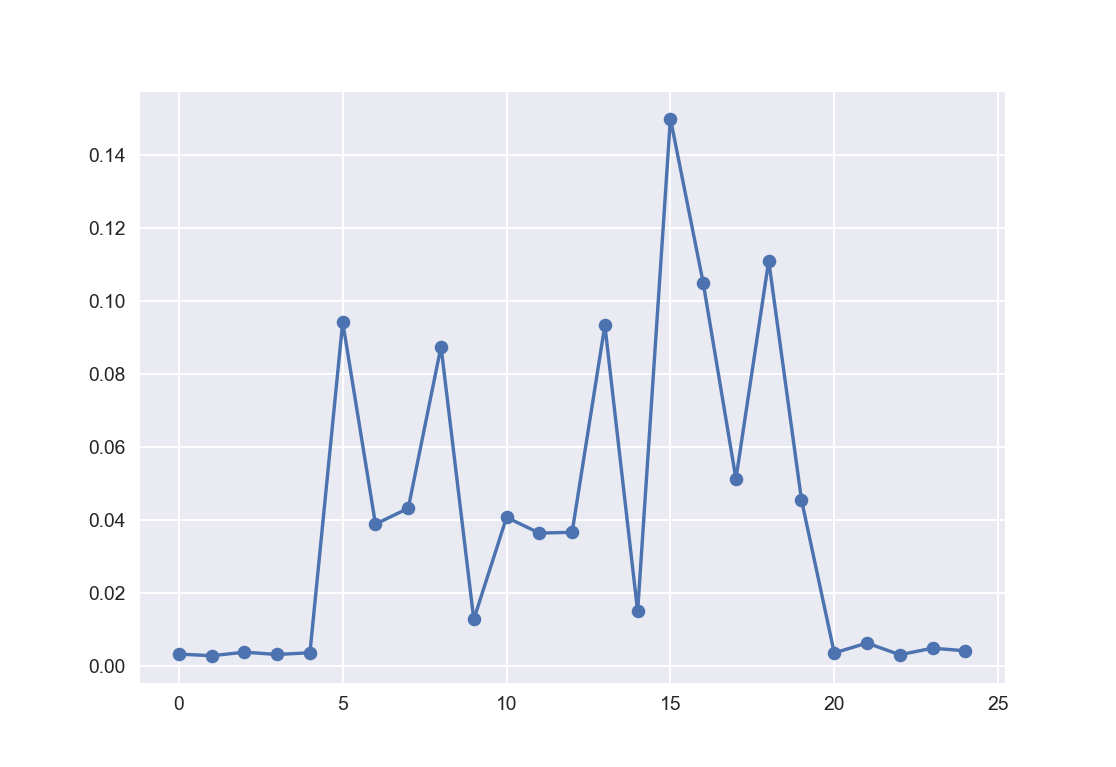

In [23]:
plt.figure()
plt.plot(I,'o-')

In [24]:
fset_dwt.shape

(500, 25)

In [25]:
fset_dwt.head(10)

feature        mean                                                  std  \
channel           0          1         2         3         4           0   
0        -15.910122  -2.778583 -0.019810  0.105215  0.024831  111.614639   
1       -217.276827  -4.761951  0.981986 -0.071850 -0.043086  126.227087   
2         48.082508   8.423689  2.650373 -0.015687  0.020661  137.245059   
3        -17.587851  -1.897547  1.398490 -0.090761  0.188800  106.789824   
4        -67.356313 -12.210923 -2.635344 -0.076370 -0.049323  127.010765   
5       -114.778308  -1.250377 -0.344709 -0.128633  0.012641  124.480035   
6        -48.023526  -6.725609 -0.958677 -0.130518  0.073476  115.039923   
7        -23.224101   3.849166  2.959065 -0.037378  0.007792   84.795605   
8         34.970533  -1.963585 -0.499454  0.054185 -0.009737  101.958626   
9       -108.954391  -5.495560 -0.167551 -0.101091 -0.067986  148.106445   

feature                                                ...        abs_diffs  \
channel           1          2          3         4    ...                0   
0         73.651977  57.599121  16.824769  3.258173    ...     25989.161492   
1        101.027412  74.034374  22.529927  4.295173    ...     28962.801712   
2         82.506171  64.044937  17.992113  3.666443    ...     32015.356381   
3         92.222478  71.483441  32.042515  8.324908    ...     27236.244982   
4         80.469924  61.376659  19.173825  4.762934    ...     24789.078872   
5         89.608758  58.548823  20.845366  3.579603    ...     25127.909775   
6        100.867478  62.145744  27.192675  4.214196    ...     24774.411151   
7         56.824551  49.168205  16.076020  2.930731    ...     19496.798511   
8         53.442121  29.172969  12.193507  3.327317    ...     22266.257346   
9         57.793449  42.288145  13.710264  2.847246    ...     25499.349898   

feature                                                              skew  \
channel             1             2             3             4         0   
0        21471.607079  42118.187563  25513.511165   8884.022474 -0.023681   
1        27803.198242  52251.941205  33440.573780  10454.981962 -0.216560   
2        21188.433149  46873.284023  27257.384189   9302.428251  0.076680   
3        26612.406851  48563.039582  47692.505774  18617.150984 -0.025470   
4        19696.481871  44379.203591  28282.506022  11671.690493  0.216075   
5        23151.489967  41621.539883  31352.889780   9338.300605  0.326366   
6        27481.271130  40352.083337  41316.115256  11315.423986  0.041601   
7        15755.498797  35011.351137  24602.471992   7998.595373  0.271797   
8        18469.194924  19171.964185  17877.743482   8335.994369 -0.186196   
9        17826.402032  29481.474566  20657.631375   7572.002928  0.422025   

feature                                          
channel         1         2         3         4  
0        0.040105 -0.031502 -0.018217  0.023613  
1        0.011901  0.298579  0.161491  0.293004  
2        0.096949  0.097362 -0.034561 -0.030424  
3       -0.269809  0.164726 -0.097929 -0.086297  
4       -0.159759 -0.121237 -0.008904  0.103132  
5       -0.278739  0.041424  0.032424  0.058485  
6       -0.124341 -0.090159  0.000885 -0.036843  
7        0.048690 -0.075242 -0.005862  0.092629  
8       -0.163326  0.033989  0.062457 -0.046366  
9       -0.233251 -0.062927  0.070383  0.214492  

[10 rows x 25 columns]